In [1]:
"""-------Immune Response Model----------"""

import numpy as np
from math import sqrt,log10,exp
import matplotlib.pyplot as plt
from stochastic.processes.continuous import FractionalBrownianMotion
from stochastic.processes.continuous import BrownianMotion
from scipy.special import gamma
import time
import os
import pandas as pd

class ImmuneResponseModel():
    """
    Parameters
    ----------
    parameters: list 
        Contains the array of parameter values [p, c, cv, r, g]
    initial_state: numpy.ndarray, optional
        Initial State Value of the model. Set to [100,100000] by default according to main text.
    n_timesteps: integer
        Total simulation steps
    t_init: integer
        Initial Timepoint (in days)
    t_final: integer
        Final Timepoint (in days)
    Hv and Ht: float
        Hurst Parameters for Virus and T-cell
    """
    def __init__(self, parameters, n_timesteps, t_init, t_final, Hv, Ht, initial_state=None):

        #set initial timepoint
        self.t_init = t_init
        #set final timepoint
        self.t_final = t_final
        #set timestep value
        self.n_timesteps = (t_final - t_init)* n_timesteps
        #set Hurst index Virus
        self.Hv = Hv
        #set Hurst index T-cell
        self.Ht = Ht
        #time increments
        self.dt = float((self.t_final - self.t_init)/self.n_timesteps)
        #set initial state
        self._set_initial_state(initial_state)


        if not isinstance(parameters, list):
            raise TypeError('Input of Immune Response model is of type list')

        if len(parameters) != 5:
            raise RuntimeError('Input list must be of length 5, containing [p, c, cv, r, g].')

    def _set_initial_state(self, initial_state):
        #set inital state of the system in the order Virus, T-cell
        if initial_state is None:
            self.initial_state = np.array([pow(10,2),pow(10,5)])
        else: 
            self.initial_state= initial_state

    def _check_input(self, input_values):
        #Check format of input parameters
        if len(input_values) != 5:
            raise ValueError('Number of parameters of Immune Response Model model must be 5.')
        p = input_values[0]
        c = input_values[1]
        cv = input_values[2]
        r = input_values[3]
        g = input_values[4]
        return True

    def _check_output(self):
        return True

    def get_number_parameters(self):
        return 5

    def get_output_dimension(self):
        return 2*self.n_timesteps
    
    def write_parameters(self, input_values, filename, output_filename, val):
        data = {'p': input_values[0], 'c': input_values[1], 'cv': input_values[2], 'r': input_values[3], 'g': input_values[4],
               'Hv': self.Hv, 'Ht': self.Ht, 'days': self.t_final, 'patient': filename, 'MSE': val}
        data_val = pd.DataFrame([data])
        
        if not os.path.isfile(output_filename):
            data_val.to_csv(output_filename, index = False)
            print('File created and data added.')
        else:
            data_val.to_csv(output_filename, index = False,mode='a',header= False)
            print('Data succesfully appended.')

    def simulatefbm(self, input_values, k, rng=np.random.RandomState()):
        """Method to simulate instances of Fractional Brownian Motion in both Viral
           and T cell populations
        """
        #extract parameters
        p = input_values[0]
        c = input_values[1]
        cv = input_values[2]
        r = input_values[3]
        g = input_values[4]

        #do the forward simulations
        simulation_result, time_unit = self.immune_response_fbm(p,c,cv,r,g,k,rng=rng)
        result_virus = [np.array(sim[0:self.n_timesteps]) for sim in simulation_result]
        result_tcell = [np.array(sim[self.n_timesteps:]) for sim in simulation_result]

        return result_virus, result_tcell, time_unit

    def simulatebm(self, input_values, k, rng=np.random.RandomState()):
        """Method to simulate instances of Brownian Motion in both Viral
           and T cell populations
        """
         #extract parameters
        p = input_values[0]
        c = input_values[1]
        cv = input_values[2]
        r = input_values[3]
        g = input_values[4]

        #do the forward simulations
        simulation_result, time_unit = self.immune_response_bm(p,c,cv,r,g,k,rng=rng)
        result_virus = [np.array(sim[0:self.n_timesteps]) for sim in simulation_result]
        result_tcell = [np.array(sim[self.n_timesteps:]) for sim in simulation_result]

        return result_virus, result_tcell, time_unit
    def simulatebmtcell(self, input_values, k, rng=np.random.RandomState()):
        """Method to simulate instances of Brownian Motion in T cell populations
        """
         #extract parameters
        p = input_values[0]
        c = input_values[1]
        cv = input_values[2]
        r = input_values[3]
        g = input_values[4]

        #do the forward simulations
        simulation_result, time_unit = self.immune_response_bm_tcell(p,c,cv,r,g,k,rng=rng)
        result_virus = [np.array(sim[0:self.n_timesteps]) for sim in simulation_result]
        result_tcell = [np.array(sim[self.n_timesteps:]) for sim in simulation_result]

        return result_virus, result_tcell, time_unit
    def simulatebmvirus(self, input_values, k, rng=np.random.RandomState()):
        """Method to simulate instances of Brownian Motion in Viral populations
        """
         #extract parameters
        p = input_values[0]
        c = input_values[1]
        cv = input_values[2]
        r = input_values[3]
        g = input_values[4]

        #do the forward simulations
        simulation_result, time_unit = self.immune_response_bm_virus(p,c,cv,r,g,k,rng=rng)
        result_virus = [np.array(sim[0:self.n_timesteps]) for sim in simulation_result]
        result_tcell = [np.array(sim[self.n_timesteps:]) for sim in simulation_result]

        return result_virus, result_tcell, time_unit

    #Generate the instances of G(t) for N timesteps, with Hurst index 1-H
    def GenerateFbm(self, H):
        fbm = FractionalBrownianMotion(hurst= 1-H, t=(self.t_final - self.t_init))  
        fbm_sample = float(sqrt(2/gamma(3-2*H))/(2*H*(2*H-1)*gamma(2*H-1)))*fbm.sample(self.n_timesteps-1)    
        return fbm_sample 

    def GenerateBm(self):
        bm = BrownianMotion(t = self.t_final - self.t_init)
        bm_sample = bm.sample(self.n_timesteps-1)
        return bm_sample

    #coefficient of summation term
    def coefficient(self, H):
        coeff = float((self.dt**(2-2*H))/((2*H*(2*H-1)*gamma(2*H-1)*gamma(3-2*H))))      
        return coeff

    #approximate coupling term in virus equation
    def force_term_virus(self,j,p,c,cv,timeseries):
        return ((p- cv) - c*timeseries[1,j-1])*timeseries[0,j-1]

    #approximate coupling term in T cell equation
    def force_term_tcell(self,j,r,g,timeseries):
        return (r*timeseries[0,j-1] - g)*timeseries[1,j-1]
    
    #Helper function used for implementation according to the numerical scheme
    def approxfun(self,n,j,p,c,cv,r,g,Hv,Ht,timeseries,flag):
        if flag == 1:
            return float(self.force_term_virus(j,p,c,cv,timeseries)*(((n-j+1)**(2-2*Hv)) - ((n-j)**(2-2*Hv))))
        elif flag == 0:
            return float(self.force_term_tcell(j,r,g,timeseries)*(((n-j+1)**(2-2*Ht)) - ((n-j)**(2-2*Ht))))
    
    #Fractional Brownian Motion
    def immune_response_fbm(self,p,c,cv,r,g,k,rng=np.random.RandomState()):
        results = []
        #initialize timesteps.
        time_steps= np.arange(self.t_init, self.t_final, self.dt)
        time_steps = np.round(time_steps,2)

        for k in range(0,k):
            #generate fbm
            noise_virus = self.GenerateFbm(self.Hv)
            noise_tcell = self.GenerateFbm(self.Ht)
            #get coefficient values
            coeff_virus = self.coefficient(self.Hv)
            coeff_tcell = self.coefficient(self.Ht)
            #initialize the time series
            timeseries = np.zeros(shape=(2, self.n_timesteps))
            timeseries[:, 0] = self.initial_state[0:2]
            for n in range(1, self.n_timesteps):
                #virus cells
                flag = 1
                timeseries[0,n] = (timeseries[0,0] + coeff_virus*sum(self.approxfun(n,j,p,c,cv,r,g,self.Hv,self.Ht,timeseries,flag)
                                                                    for j in range(1,n+1))+ noise_virus[n])
                #T cells
                flag = 0
                timeseries[1,n] = (timeseries[1,0] + coeff_tcell*sum(self.approxfun(n,j,p,c,cv,r,g,self.Hv,self.Ht,timeseries,flag)
                                                                     for j in range(1,n+1))+ noise_tcell[n])
            results.append(timeseries.flatten())
        return results,time_steps
    
    #Brownian Motion
    def immune_response_bm(self,p,c,cv,r,g,k,rng=np.random.RandomState()):
        results = []
        #initialize timesteps.
        time_steps= np.arange(self.t_init, self.t_final, self.dt)
        time_steps = np.round(time_steps,2)

        for k in range(0,k):
            #generate bm
            noise_virus = self.GenerateBm()
            noise_tcell = self.GenerateBm()
            #initialize the time series
            timeseries = np.zeros(shape=(2, self.n_timesteps))
            timeseries[:, 0] = self.initial_state[0:2]
            for n in range(1, self.n_timesteps):
                #virus cells
                timeseries[0,n] = (timeseries[0,n-1] + self.dt*self.force_term_virus(n,p,c,cv,timeseries) 
                                   + (noise_virus[n] - noise_virus[n-1]))
                #T cells
                timeseries[1,n] = (timeseries[1,n-1] + self.dt*self.force_term_tcell(n,r,g,timeseries) 
                                   + (noise_tcell[n] - noise_tcell[n-1]))
            results.append(timeseries.flatten())
        return results,time_steps
    
    #Brownian Motion T cell
    def immune_response_bm_tcell(self,p,c,cv,r,g,k,rng=np.random.RandomState()):
        results = []
        #initialize timesteps.
        time_steps= np.arange(self.t_init, self.t_final, self.dt)
        time_steps = np.round(time_steps,2)

        for k in range(0,k):
            #generate fbm virus
            noise_virus = self.GenerateFbm(self.Hv)
            #generate bm T cell
            noise_tcell = self.GenerateBm()
            coeff_virus = self.coefficient(self.Hv)
            #initialize the time series
            timeseries = np.zeros(shape=(2, self.n_timesteps))
            timeseries[:, 0] = self.initial_state[0:2]
            for n in range(1, self.n_timesteps):
                #virus cells
                timeseries[0,n] = (timeseries[0,0] + coeff_virus*sum(self.approxfun(n,j,p,c,cv,r,g,self.Hv,self.Ht,timeseries,1)
                                                                    for j in range(1,n+1))+ noise_virus[n])
                #T cells
                timeseries[1,n] = (timeseries[1,n-1] + self.dt*self.force_term_tcell(n,r,g,timeseries) 
                                   + (noise_tcell[n] - noise_tcell[n-1]))
            results.append(timeseries.flatten())
        return results,time_steps
    
    #Brownian Motion Virus
    def immune_response_bm_virus(self,p,c,cv,r,g,k,rng=np.random.RandomState()):
        results = []
        #initialize timesteps.
        time_steps= np.arange(self.t_init, self.t_final, self.dt)
        time_steps = np.round(time_steps,2)

        for k in range(0,k):
            #generate bm virus
            noise_virus = self.GenerateBm()
            #generate fbm T cell
            noise_tcell = self.GenerateFbm(self.Ht)
            coeff_tcell = self.coefficient(self.Ht)
            #initialize the time series
            timeseries = np.zeros(shape=(2, self.n_timesteps))
            timeseries[:, 0] = self.initial_state[0:2]
            for n in range(1, self.n_timesteps):
                #virus cells
                timeseries[0,n] = (timeseries[0,n-1] + self.dt*self.force_term_virus(n,p,c,cv,timeseries) 
                                   + (noise_virus[n] - noise_virus[n-1]))
                #T cells
                timeseries[1,n] = (timeseries[1,0] + coeff_tcell*sum(self.approxfun(n,j,p,c,cv,r,g,self.Hv,self.Ht,timeseries,0)
                                                                     for j in range(1,n+1))+ noise_tcell[n])
            results.append(timeseries.flatten())
        return results,time_steps

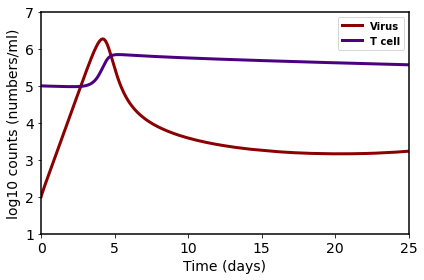

Execution Time: 9.935139417648315


In [2]:
#Run simulation for fbm, bm, bm in virus and bm in T cell
import PIL
from decimal import *

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

begin = time.time()

#set hurst index
Hv = 0.55
Ht = 0.55

#set initial and final time (days)
t_init = 0
t_final = 25

#input parameters: [p, c, cv, r, g]
input_values = [5.8, pow(10,-5), 2.4, pow(10,-6), 0.03]

#call immune response class
immune = ImmuneResponseModel(input_values, 100, t_init, t_final, Hv, Ht, initial_state = np.array([pow(10,2),pow(10,5)]))

#for generating instances of population change driven by Gaussian Noise
#obs_virus_bm, obs_tcell_bm, time_step = immune.simulatebm(input_values, k=1) 

#for generating instances of population change driven by Fractional Gaussian Noise
obs_virus, obs_tcell, time_step = immune.simulatefbm(input_values, k=1) 

#for generating instances of population change driven by Fractional Gaussian Noise in Virus
#obs_virus_bmtcell, obs_tcell_bmtcell, time_step = immune.simulatebmtcell(input_values, k=1) 

#for generating instances of population change driven by Fractional Gaussian Noise in T cell
#obs_virus_bmvirus, obs_tcell_bmvirus, time_step = immune.simulatebmvirus(input_values, k=1) 

#Plotting function
fig = plt.figure()
plt.plot(time_step, np.log10(np.ma.array(obs_virus[0], mask=(obs_virus[0]<=10))), label = 'Virus', color = 'darkred', linewidth=3)
plt.plot(time_step, np.log10(obs_tcell[0]), label = 'T cell', color = 'indigo', linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('log10 counts (numbers/ml)')
plt.ylim((1,7))
plt.xlim((0,25))
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(1.5)
plt.rcParams["font.weight"] = 'bold'
plt.rcParams["axes.labelweight"] = 'bold'
plt.legend()
plt.tight_layout()
# plt.savefig('dual.png', dpi= 600)
# plt.savefig('dual.tiff', dpi= 600)
plt.show()   

end = time.time()
print(f'Execution Time: {end - begin}') 